# Project 2

## Dependencies
- Pip Packages
    - fredapi
    - pandas
- General
    - FRED API Key
    
## Table of Contents

- [Get FRED Data](#Get-FRED-Data)
- [US Data](#US-Data)
- [Data Cleaning](#Data-Cleaning)
- [Plots](#Plots)
- [Feature Selection](#Feature-Selection)
- [Models](#Models)
- [Reporting](#Reporting)
- [Canada Data](#Canada-Data)

_PS: You can use the above anchors when you're in the Jupyter Notebook or in the HTML. Try clicking on one!_

In [381]:
#pip install pandas_datareader
#You may need to uncomment above line and run so you have needed libraries

In [382]:
from fredapi import Fred
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from functools import reduce
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Get FRED Data

In [383]:
# Key: 02d60bd3174b5444867a02671ae80475
api_key = input("Please input your FRED API Key:\n").strip()
fred = Fred(api_key=api_key)

Please input your FRED API Key:
02d60bd3174b5444867a02671ae80475


## US Data
- US Recession Index (FRED)
- US GDP (FRED)
- US GDP Percent Change (Calculated)
- U.S. Unemployment Rate (FRED)
- U.S. Unemployment Rate % Change (Calculated)
- SP500 (Yahoo Finance)
- NASDAQ100 (FRED)
- Treasury Yield Curve (FRED)

In [384]:
def get_fred_series(name: str, date: str, label: str, to_frame: bool = True, pct_change: bool = False, periods: int = None, freq=None):
    """ Gets the FRED Series in Name, from Date, and inputs the data into a label 
        Assumes that data is in format of: "date", "value"
    """
    series = fred.get_series(name)
    if to_frame:
        series = series.to_frame()
    if pct_change:
        if not freq and not periods:
            series = series.pct_change()
        elif freq:
            series = series.pct_change(freq=freq)
        elif periods:
            series = series.pct_change(periods=periods)
    series = series.loc[date:]
    series[label] = series[0]
    return series.drop(columns = 0)

In [385]:
us_rec = get_fred_series('JHDUSRGDPBR', '1970-01-01', 'is_recession')
us_rec

,is_recession
1970-01-01,1.0
1970-04-01,1.0
1970-07-01,1.0
1970-10-01,1.0
1971-01-01,0.0
...,...
2019-04-01,0.0
2019-07-01,0.0
2019-10-01,1.0
2020-01-01,1.0


In [386]:
us_gdp = get_fred_series('GDP', '1970-01-01', 'US_GDP')
us_gdp['US_GDP']*1000000000

1970-01-01    1.051200e+12
1970-04-01    1.067375e+12
1970-07-01    1.086059e+12
1970-10-01    1.088608e+12
1971-01-01    1.135156e+12
                  ...     
2019-07-01    2.154032e+13
2019-10-01    2.174739e+13
2020-01-01    2.156114e+13
2020-04-01    1.952011e+13
2020-07-01    2.115712e+13
Name: US_GDP, Length: 203, dtype: float64

In [387]:
us_gdp_pctcg = get_fred_series('GDP', '1970-01-01', 'US_GDP_%Change', pct_change=True)
us_gdp_pctcg

,US_GDP_%Change
1970-01-01,0.012573
1970-04-01,0.015387
1970-07-01,0.017505
1970-10-01,0.002347
1971-01-01,0.042759
...,...
2019-07-01,0.009866
2019-10-01,0.009613
2020-01-01,-0.008564
2020-04-01,-0.094662


In [388]:
unemp = fred.get_series('UNRATE').loc['1970-01-01':].to_frame()
unemp['US Unemp'] = unemp[0]
unemp = unemp.drop(columns = 0).iloc[::3, :]
unemp

,US Unemp
1970-01-01,3.9
1970-04-01,4.6
1970-07-01,5.0
1970-10-01,5.5
1971-01-01,5.9
...,...
2019-10-01,3.6
2020-01-01,3.6
2020-04-01,14.7
2020-07-01,10.2


In [389]:
unemp = get_fred_series('UNRATE', '1970-01-01', 'US Unemp')
unemp = unemp.iloc[::3, :]
unemp

,US Unemp
1970-01-01,3.9
1970-04-01,4.6
1970-07-01,5.0
1970-10-01,5.5
1971-01-01,5.9
...,...
2019-10-01,3.6
2020-01-01,3.6
2020-04-01,14.7
2020-07-01,10.2


In [390]:
unemp_pct = get_fred_series('UNRATE', '1970-01-01', 'US Unemp % Change', pct_change=True, periods=3)
unemp_pct

,US Unemp % Change
1970-01-01,0.054054
1970-02-01,0.200000
1970-03-01,0.257143
1970-04-01,0.179487
1970-05-01,0.142857
...,...
2020-07-01,-0.306122
2020-08-01,-0.368421
2020-09-01,-0.288288
2020-10-01,-0.323529


In [391]:
sp500 = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today())
sp500.rename(columns = {'Adj Close' : "SPX500 % Change"}, inplace=True)
sp500 = sp500["SPX500 % Change"].pct_change().to_frame()
sp500

,SPX500 % Change
Date,
1970-01-02,NaN
1970-01-05,0.004946
1970-01-06,-0.006848
1970-01-07,-0.002047
1970-01-08,0.000540
...,...
2020-11-30,-0.004596
2020-12-01,0.011271
2020-12-02,0.001791


In [392]:
nascom = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM')
nascom

,NASDAQCOM
1971-02-05,100.00
1971-02-08,100.84
1971-02-09,100.76
1971-02-10,100.69
1971-02-11,101.45
...,...
2020-11-27,12205.85
2020-11-30,12198.74
2020-12-01,12355.11
2020-12-02,12349.37


In [393]:
nascom.resample('M').sum()


,NASDAQCOM
1971-02-28,1514.450000
1971-03-31,2402.820000
1971-04-30,2300.660000
1971-05-31,2191.410000
1971-06-30,2388.490000
...,...
2020-08-31,235458.098000
2020-09-30,232862.270000
2020-10-31,251575.145000
2020-11-30,235889.226133


In [394]:
nascom_pct = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM % Chg', pct_change=True, freq='Q')
nascom_pct

,NASDAQCOM % Chg
1971-02-05,NaN
1971-02-08,NaN
1971-02-09,NaN
1971-02-10,NaN
1971-02-11,NaN
...,...
2020-11-27,NaN
2020-11-30,NaN
2020-12-01,NaN
2020-12-02,NaN


In [395]:
nascom_pct = nascom_pct.loc[nascom_pct['NASDAQCOM % Chg'].notnull() == True]
nascom_pct.index = nascom_pct.index + pd.Timedelta('1 day')
nascom_pct

,NASDAQCOM % Chg
1971-04-01,0.059700
1971-07-01,0.017269
1971-10-01,0.011410
1972-01-01,0.046684
1972-04-01,0.122853
...,...
2019-10-01,-0.011349
2020-01-01,0.121668
2020-04-01,-0.141821
2020-07-01,0.306317


In [396]:
ycurve = get_fred_series('T10Y2Y', '1970-01-01', '10Y-2Y')
ycurve

,10Y-2Y
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79
...,...
2020-11-30,0.68
2020-12-01,0.75
2020-12-02,0.79
2020-12-03,0.76


In [397]:
us_inflation = get_fred_series('FPCPITOTLZGUSA', '1970-01-01', 'US Inflation')
us_inflation

,US Inflation
1970-01-01,5.838255
1971-01-01,4.292767
1972-01-01,3.272278
1973-01-01,6.177760
1974-01-01,11.054805
1975-01-01,9.143147
1976-01-01,5.744813
1977-01-01,6.501684
1978-01-01,7.630964
1979-01-01,11.254471


In [398]:
us_inflation_pctch = get_fred_series('FPCPITOTLZGUSA', '1970-01-01', 'US Inflation % Change', pct_change=True)
us_inflation_pctch

,US Inflation % Change
1970-01-01,0.068810
1971-01-01,-0.264718
1972-01-01,-0.237723
1973-01-01,0.887908
1974-01-01,0.789452
1975-01-01,-0.172926
1976-01-01,-0.371681
1977-01-01,0.131749
1978-01-01,0.173690
1979-01-01,0.474843


In [399]:
us_employees = get_fred_series('MANEMP', '1970-01-01', 'US ManufactureEmps')
us_employees

,US ManufactureEmps
1970-01-01,18424.0
1970-02-01,18361.0
1970-03-01,18360.0
1970-04-01,18207.0
1970-05-01,18029.0
...,...
2020-07-01,12103.0
2020-08-01,12133.0
2020-09-01,12193.0
2020-10-01,12226.0


In [400]:
us_employees_chg = get_fred_series('MANEMP', '1970-01-01', 'US ManuEmps % Change', pct_change = True)
#us_employees_chg = us_employees_chg.pct_change().loc['1970-01-01':]
us_employees_chg

,US ManuEmps % Change
1970-01-01,-0.003300
1970-02-01,-0.003419
1970-03-01,-0.000054
1970-04-01,-0.008333
1970-05-01,-0.009776
...,...
2020-07-01,0.003399
2020-08-01,0.002479
2020-09-01,0.004945
2020-10-01,0.002706


In [401]:
us_loans_pctchg = get_fred_series('TOTCI', '1970-01-01', 'US Loans % Change', pct_change = True, freq = 'Q')
us_loans_pctchg

,US Loans % Change
1973-01-03,NaN
1973-01-10,NaN
1973-01-17,NaN
1973-01-24,NaN
1973-01-31,NaN
...,...
2020-10-28,NaN
2020-11-04,NaN
2020-11-11,NaN
2020-11-18,NaN


In [402]:
us_loans_pctchg = us_loans_pctchg.loc[us_loans_pctchg['US Loans % Change'].notnull() == True]
us_loans_pctchg.index = us_loans_pctchg.index + pd.Timedelta('1 day')
us_loans_pctchg

,US Loans % Change
1976-01-01,0.003187
1976-04-01,-0.030793
1976-07-01,0.009077
1981-01-01,0.049482
1981-10-01,0.030082
1982-04-01,0.039701
1982-07-01,0.044378
1987-01-01,0.067304
1987-10-01,0.020066
1992-10-01,-0.005345


In [403]:
med_income = get_fred_series('MEHOINUSA672N', '1970-01-01', 'US Median Income').dropna()
med_income

,US Median Income
1984-01-01,52679.0
1985-01-01,53664.0
1986-01-01,55597.0
1987-01-01,56261.0
1988-01-01,56725.0
1989-01-01,57705.0
1990-01-01,56966.0
1991-01-01,55302.0
1992-01-01,54874.0
1993-01-01,54581.0


In [404]:
med_income_pct = get_fred_series('MEHOINUSA672N', '1970-01-01', 'US Median Income % Chg', pct_change = True).dropna()
med_income_pct

,US Median Income % Chg
1985-01-01,0.018698
1986-01-01,0.036020
1987-01-01,0.011943
1988-01-01,0.008247
1989-01-01,0.017276
1990-01-01,-0.012807
1991-01-01,-0.029210
1992-01-01,-0.007739
1993-01-01,-0.005340
1994-01-01,0.011616


In [405]:
'''outer = [us_rec, us_gdp, us_gdp_pctcg, unemp, unemp_pct, us_inflation, sp500,  med_income]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='outer'), outer)
inner = [df_merged, nascom_pct, ycurve, us_employees, us_employees_chg]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='inner'), inner)
df_merged = df_merged.iloc[:-2].fillna(method = 'ffill')
df_merged['US Inflation'].fillna((df_merged['US Inflation'].mean()), inplace=True)
df_merged['US Median Income'].fillna((df_merged['US Median Income'].mean()), inplace=True)'''



"outer = [us_rec, us_gdp, us_gdp_pctcg, unemp, unemp_pct, us_inflation, sp500,  med_income]\ndf_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,\n                                                how='outer'), outer)\ninner = [df_merged, nascom_pct, ycurve, us_employees, us_employees_chg]\ndf_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,\n                                                how='inner'), inner)\ndf_merged = df_merged.iloc[:-2].fillna(method = 'ffill')\ndf_merged['US Inflation'].fillna((df_merged['US Inflation'].mean()), inplace=True)\ndf_merged['US Median Income'].fillna((df_merged['US Median Income'].mean()), inplace=True)"

## Data Cleaning

In [406]:
# Macro: GDP,Unemployment, Inflation, Debt, ycurve, Manufacturing Employees
# Micro: SPX500, NASDAQCOM, Income

# Add a % Change for US Inflation
# Mathew will take care of the prerecorded NaN's

outer = [us_rec, us_gdp, us_gdp_pctcg, unemp, unemp_pct, us_inflation, us_inflation_pctch, sp500,  med_income, med_income_pct, nascom_pct, ycurve, us_employees_chg]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='outer'), outer)
inner = [df_merged, us_employees]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='inner'), inner)

# This line fills all nan values to most recent reported nan value reported in a column
df_merged = df_merged.iloc[:-2].fillna(method = 'ffill')
'''
# Because these 4 are reported at a later date, it fills the nan values previously to the average of all vals
df_merged.loc[df_merged['is_recession']==1, 'US Median Income'] = df_merged.loc[df_merged['is_recession']==1, 'US Median Income'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'US Median Income'])
df_merged.loc[df_merged['is_recession']==1, 'US Median Income % Chg'] = df_merged.loc[df_merged['is_recession']==1, 'US Median Income % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'US Median Income % Chg'])
df_merged.loc[df_merged['is_recession']==1, 'SPX500 % Change'] = df_merged.loc[df_merged['is_recession']==1, 'SPX500 % Change'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'SPX500 % Change'])
df_merged.loc[df_merged['is_recession']==1, 'NASDAQCOM % Chg'] = df_merged.loc[df_merged['is_recession']==1, 'NASDAQCOM % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'NASDAQCOM % Chg'])
df_merged.loc[df_merged['is_recession']==1, '10Y-2Y'] = df_merged.loc[df_merged['is_recession']==1, '10Y-2Y'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, '10Y-2Y'])

df_merged.loc[df_merged['is_recession']==0, 'US Median Income'] = df_merged.loc[df_merged['is_recession']==0, 'US Median Income'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'US Median Income'])
df_merged.loc[df_merged['is_recession']==0, 'US Median Income % Chg'] = df_merged.loc[df_merged['is_recession']==0, 'US Median Income % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'US Median Income % Chg'])
df_merged.loc[df_merged['is_recession']==0, 'SPX500 % Change'] = df_merged.loc[df_merged['is_recession']==0, 'SPX500 % Change'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'SPX500 % Change'])
df_merged.loc[df_merged['is_recession']==0, 'NASDAQCOM % Chg'] = df_merged.loc[df_merged['is_recession']==0, 'NASDAQCOM % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'NASDAQCOM % Chg'])
df_merged.loc[df_merged['is_recession']==0, '10Y-2Y'] = df_merged.loc[df_merged['is_recession']==0, '10Y-2Y'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, '10Y-2Y'])
df_merged
'''
df_merged

,is_recession,US_GDP,US_GDP_%Change,US Unemp,US Unemp % Change,US Inflation,US Inflation % Change,SPX500 % Change,US Median Income,US Median Income % Chg,NASDAQCOM % Chg,10Y-2Y,US ManuEmps % Change,US ManufactureEmps
1970-01-01,1.0,1051.200,0.012573,3.9,0.054054,5.838255,0.068810,NaN,NaN,NaN,NaN,NaN,-0.003300,18424.0
1970-02-01,1.0,1051.200,0.012573,3.9,0.200000,5.838255,0.068810,NaN,NaN,NaN,NaN,NaN,-0.003419,18361.0
1970-03-01,1.0,1051.200,0.012573,3.9,0.257143,5.838255,0.068810,NaN,NaN,NaN,NaN,NaN,-0.000054,18360.0
1970-04-01,1.0,1067.375,0.015387,4.6,0.179487,5.838255,0.068810,0.004909,NaN,NaN,NaN,NaN,-0.008333,18207.0
1970-05-01,1.0,1067.375,0.015387,4.6,0.142857,5.838255,0.068810,-0.000981,NaN,NaN,NaN,NaN,-0.009776,18029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,0.0,19520.114,-0.094662,14.7,2.800000,1.812210,-0.258076,-0.028059,68703.0,0.068077,-0.141821,0.44,0.020890,11729.0
2020-06-01,0.0,19520.114,-0.094662,14.7,1.522727,1.812210,-0.258076,0.003751,68703.0,0.068077,-0.141821,0.52,0.028391,12062.0
2020-07-01,0.0,21157.122,0.083863,10.2,-0.306122,1.812210,-0.258076,0.005022,68703.0,0.068077,0.306317,0.52,0.003399,12103.0
2020-08-01,0.0,21157.122,0.083863,10.2,-0.368421,1.812210,-0.258076,0.005022,68703.0,0.068077,0.306317,0.52,0.002479,12133.0


In [407]:
### Made the averaging a function so that we can use this later, if needed

def average_nan(merged: pd.DataFrame, columns: list) -> pd.DataFrame:
    """ Averages the null values based on recession """
    target = 'is_recession'
    for col in columns:
        merged.loc[merged[target] == 1, col] = merged.loc[
            merged[target] == 1, col].fillna( 
                merged.groupby([target]).mean().loc[1.0, col]
        )
        
        merged.loc[merged[target] == 0, col] = merged.loc[
            merged[target]==0, col].fillna( 
                merged.groupby([target]).mean().loc[0.0, col]
        )
    return merged

nan_cols = ['US Median Income', 'US Median Income % Chg', 'SPX500 % Change', 'NASDAQCOM % Chg', '10Y-2Y']
df_merged = average_nan(df_merged, nan_cols)

In [408]:
df_merged

,is_recession,US_GDP,US_GDP_%Change,US Unemp,US Unemp % Change,US Inflation,US Inflation % Change,SPX500 % Change,US Median Income,US Median Income % Chg,NASDAQCOM % Chg,10Y-2Y,US ManuEmps % Change,US ManufactureEmps
1970-01-01,1.0,1051.200,0.012573,3.9,0.054054,5.838255,0.068810,-0.000626,60120.5,-0.007593,-0.029593,0.356429,-0.003300,18424.0
1970-02-01,1.0,1051.200,0.012573,3.9,0.200000,5.838255,0.068810,-0.000626,60120.5,-0.007593,-0.029593,0.356429,-0.003419,18361.0
1970-03-01,1.0,1051.200,0.012573,3.9,0.257143,5.838255,0.068810,-0.000626,60120.5,-0.007593,-0.029593,0.356429,-0.000054,18360.0
1970-04-01,1.0,1067.375,0.015387,4.6,0.179487,5.838255,0.068810,0.004909,60120.5,-0.007593,-0.029593,0.356429,-0.008333,18207.0
1970-05-01,1.0,1067.375,0.015387,4.6,0.142857,5.838255,0.068810,-0.000981,60120.5,-0.007593,-0.029593,0.356429,-0.009776,18029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,0.0,19520.114,-0.094662,14.7,2.800000,1.812210,-0.258076,-0.028059,68703.0,0.068077,-0.141821,0.440000,0.020890,11729.0
2020-06-01,0.0,19520.114,-0.094662,14.7,1.522727,1.812210,-0.258076,0.003751,68703.0,0.068077,-0.141821,0.520000,0.028391,12062.0
2020-07-01,0.0,21157.122,0.083863,10.2,-0.306122,1.812210,-0.258076,0.005022,68703.0,0.068077,0.306317,0.520000,0.003399,12103.0
2020-08-01,0.0,21157.122,0.083863,10.2,-0.368421,1.812210,-0.258076,0.005022,68703.0,0.068077,0.306317,0.520000,0.002479,12133.0


## Plots

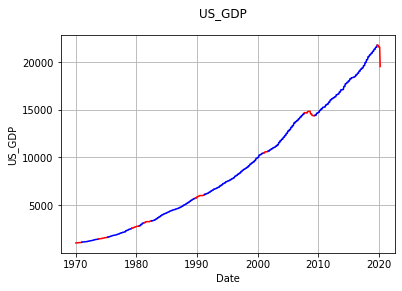

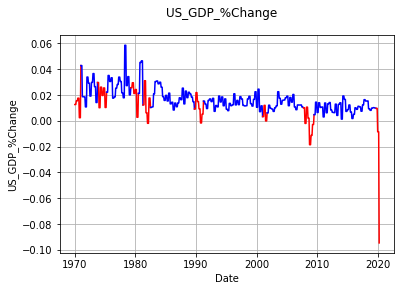

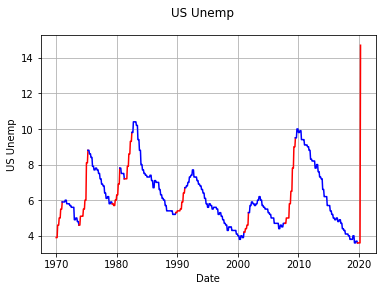

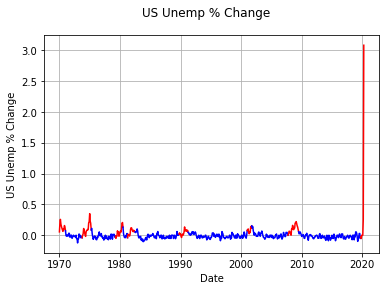

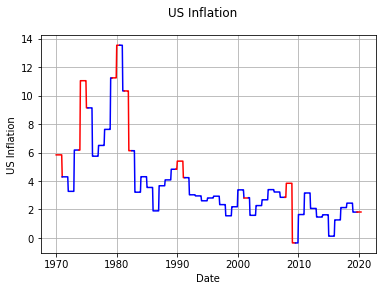

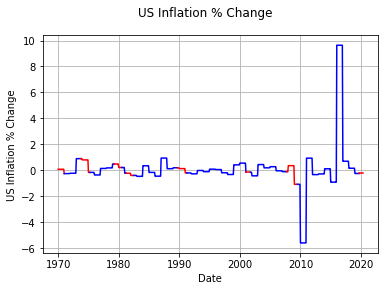

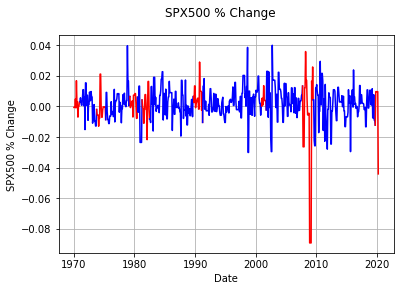

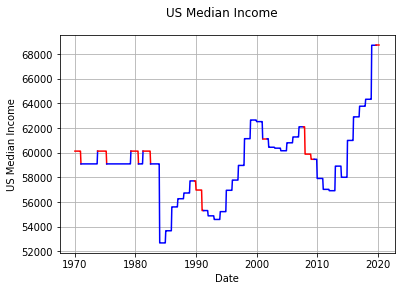

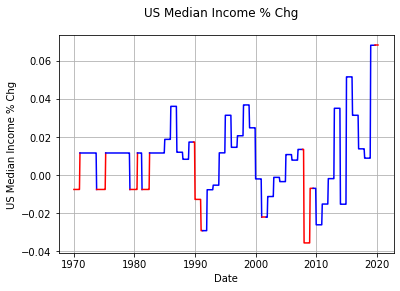

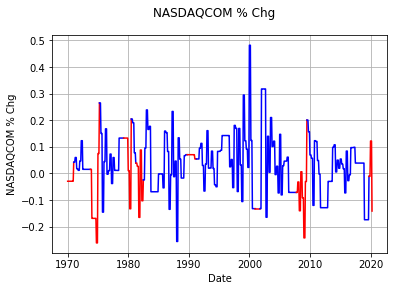

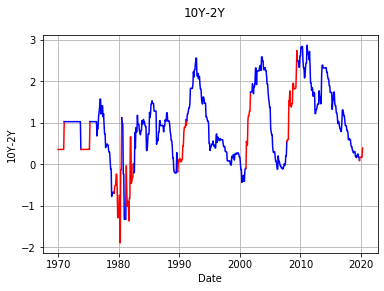

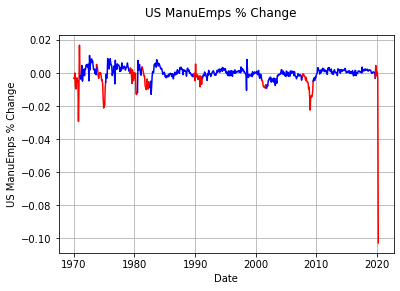

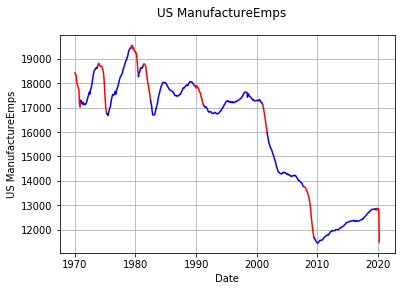

In [409]:
import numpy
from matplotlib import pyplot as plt

for column in df_merged.columns[1:]:
    fig = plt.figure()
    fig.suptitle(column)
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.grid()
    x=[]
    y=[]
    r=0
    for date, row in df_merged.iterrows():
        x.append(date.to_pydatetime())
        y.append(row[column])
        if r != row['is_recession']:
            if row['is_recession'] == 0:
                r=0
                plt.plot(x, y, 'r')
            else:
                r=1
                plt.plot(x, y, 'b')
            x=[date.to_pydatetime()]
            y=[row[column]]
    plt.show()
        

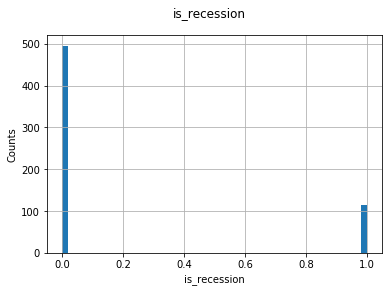

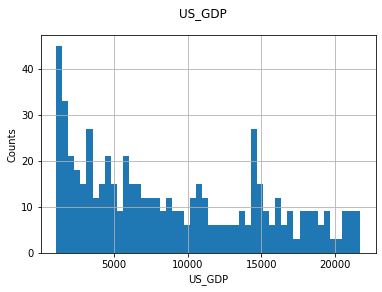

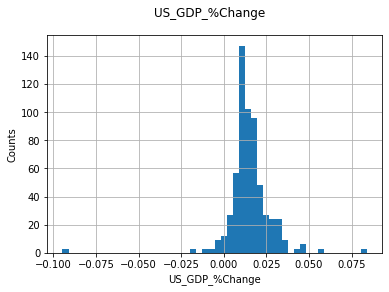

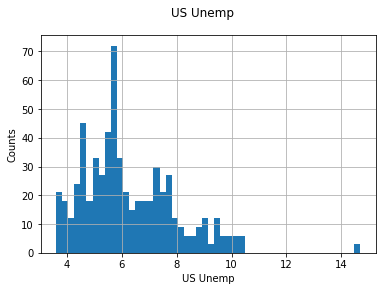

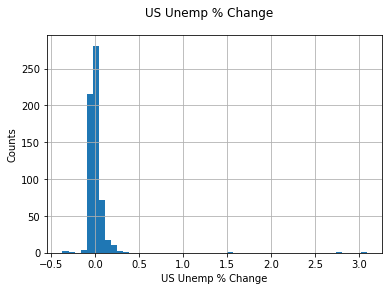

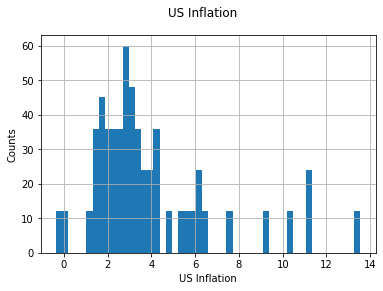

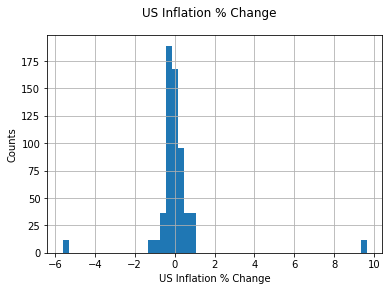

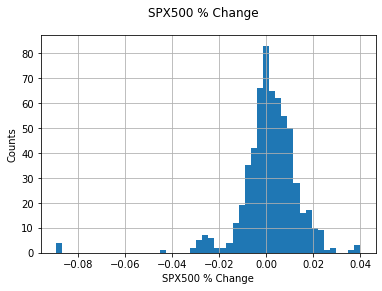

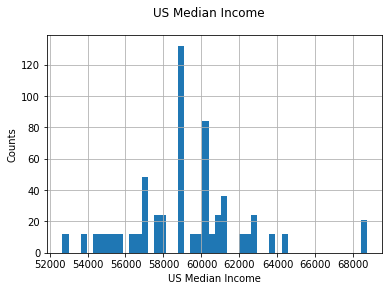

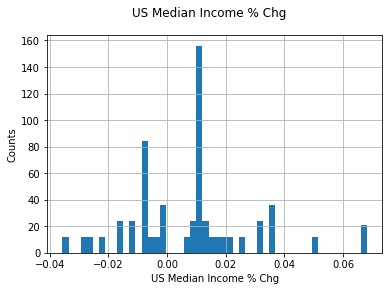

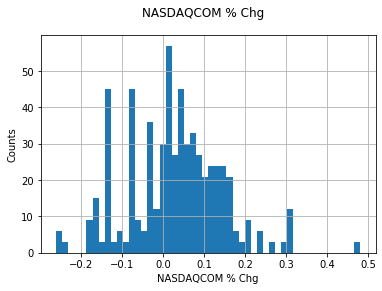

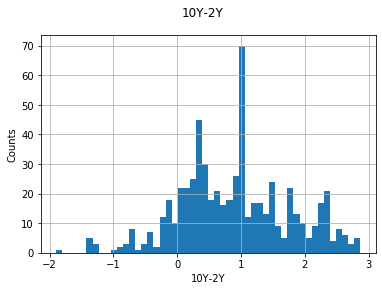

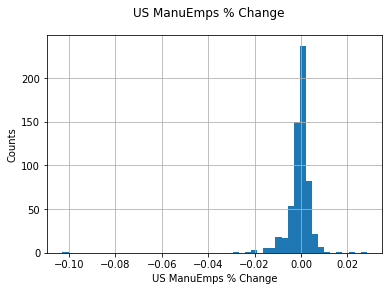

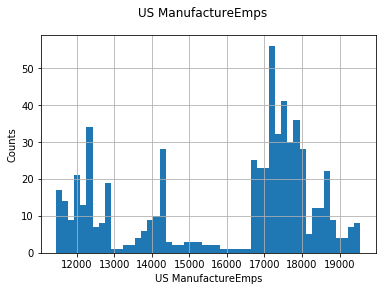

In [410]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

for column in df_merged.columns:
    fig = plt.figure()
    fig.suptitle(column)
    plt.xlabel(column)
    plt.ylabel("Counts")
    df_merged[column].hist(bins=50)
    plt.show()

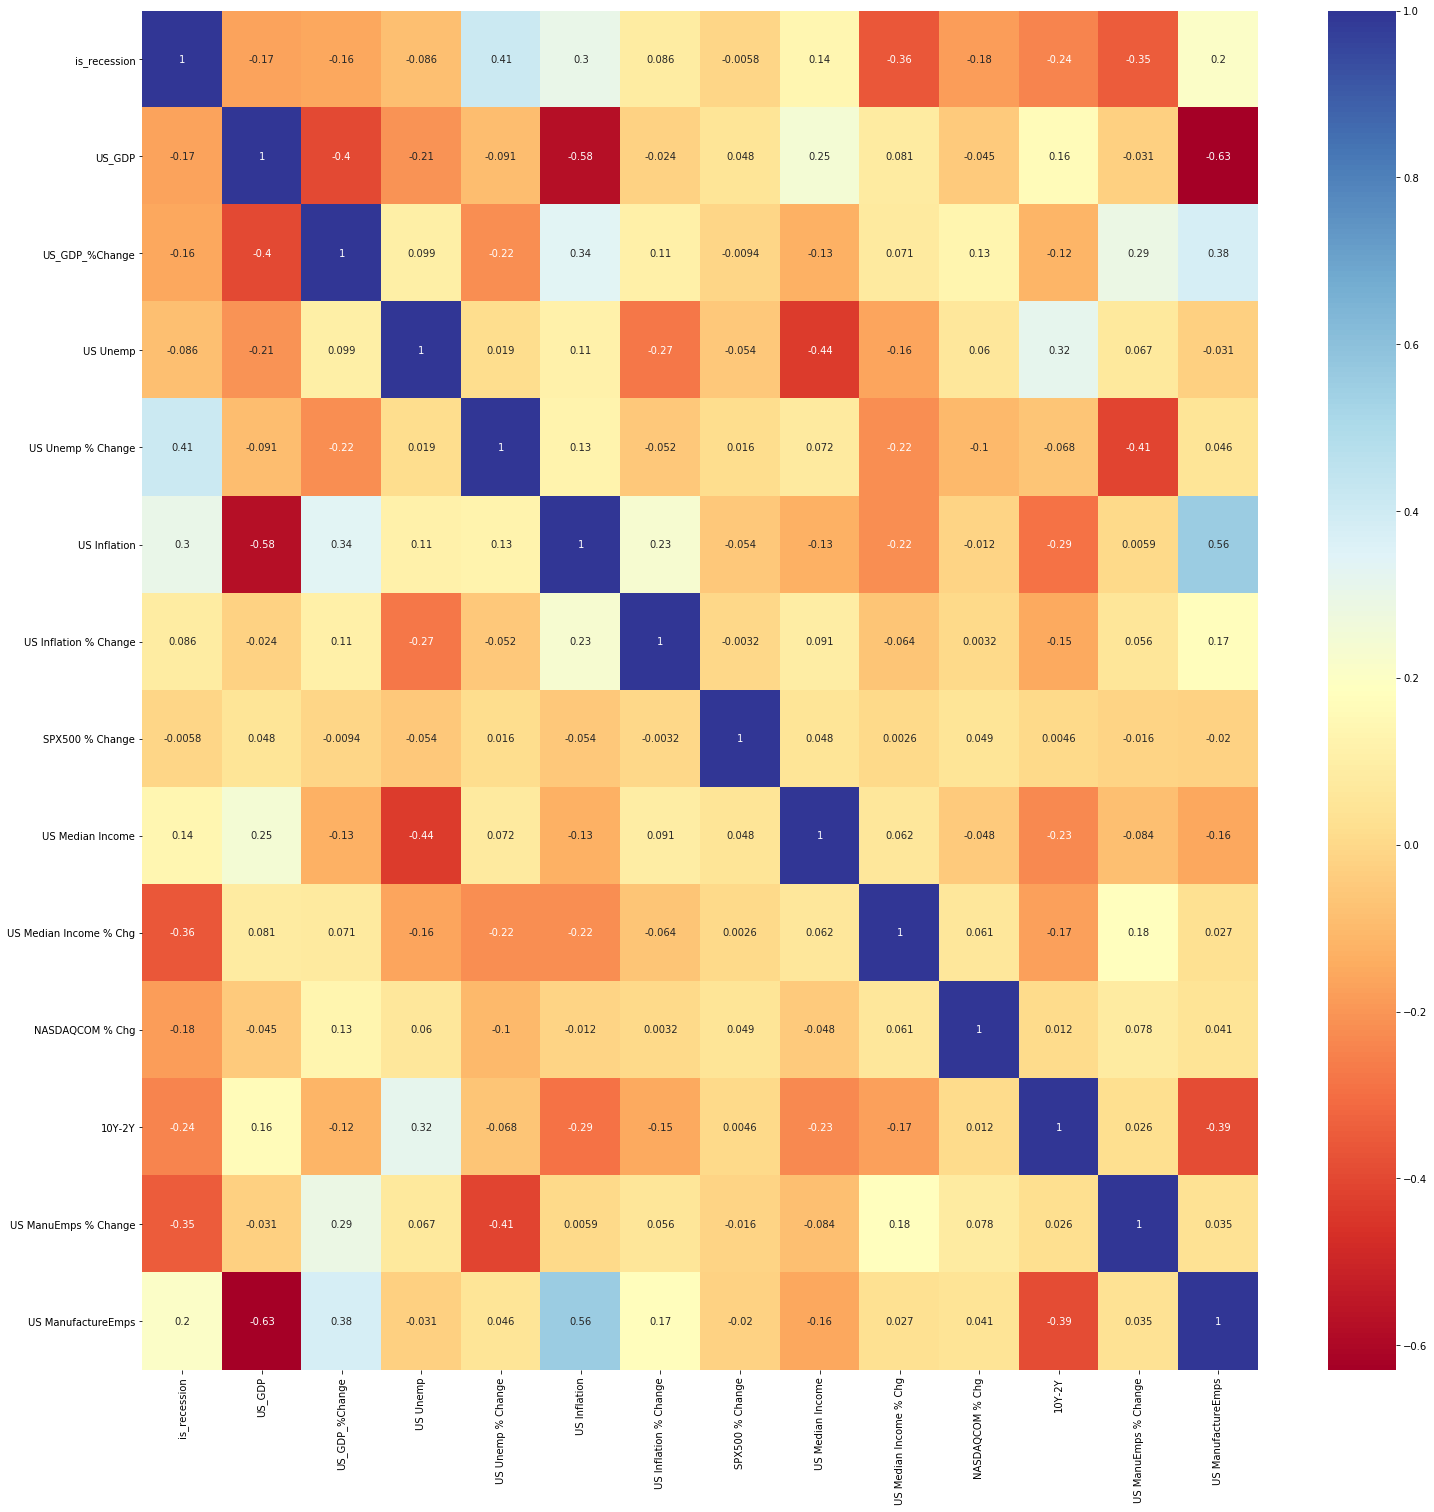

In [411]:
corr = df_merged.corr(method='kendall')
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True, cmap="RdYlBu")

## Feature Selection

In [412]:
percent_chg_col = {'US_GDP_%Change', 'US Unemp % Change', 'US Inflation % Change', 
                   'SPX500 % Change', 'NASDAQCOM % Chg', 'US ManuEmps % Change', 'US Median Income % Chg'}
num_col = {'US_GDP', 'US Unemp', 'US Inflation', 'US Median Income', '10Y-2Y', 'US ManufactureEmps'}
macro_col = {'US_GDP', 'US Unemp', 'US Inflation', '10Y-2Y', 'US ManufactureEmps', 'US_GDP_%Change', 
             'US Unemp % Change', 'US Inflation % Change', 'US ManuEmps % Change'}
micro_col = {'SPX500 % Change', 'NASDAQCOM % Chg', 'US Median Income', 'US Median Income % Chg'}
target = {'is_recession'}

### Micro: Percent & Raw

In [413]:
micro_pct = df_merged[list(micro_col - num_col)]
micro_raw = df_merged[list(micro_col - percent_chg_col)]
micro_pct.columns, micro_raw.columns

(Index(['SPX500 % Change', 'US Median Income % Chg', 'NASDAQCOM % Chg'], dtype='object'),
 Index(['US Median Income'], dtype='object'))

### Macro: Percent & Raw

In [414]:
macro_pct = df_merged[list(macro_col - num_col)]
macro_raw = df_merged[list(macro_col - percent_chg_col)]
macro_pct.columns, macro_raw.columns

(Index(['US_GDP_%Change', 'US Unemp % Change', 'US Inflation % Change',
        'US ManuEmps % Change'],
       dtype='object'),
 Index(['US_GDP', '10Y-2Y', 'US Unemp', 'US Inflation', 'US ManufactureEmps'], dtype='object'))

### All: Percent & Raw

In [415]:
all_pct = df_merged[list(percent_chg_col)]
all_raw = df_merged[list(num_col)]
all_pct.columns, all_raw.columns

(Index(['US_GDP_%Change', 'US Median Income % Chg', 'NASDAQCOM % Chg',
        'SPX500 % Change', 'US Inflation % Change', 'US ManuEmps % Change',
        'US Unemp % Change'],
       dtype='object'),
 Index(['US_GDP', 'US Median Income', '10Y-2Y', 'US Unemp', 'US Inflation',
        'US ManufactureEmps'],
       dtype='object'))

### All: ANOVA Selection

In [416]:
from sklearn.feature_selection import SelectKBest, f_classif

def get_k_best(X: pd.DataFrame, y: pd.DataFrame, k: int = 5) -> list:
    """ Takes in a data frame and reports the top K features """
    fit = SelectKBest(score_func=f_classif, k=k).fit(np.array(X), np.array(y).reshape(y.shape[0]))
    values = fit.transform(np.array(X))
    frozen = [frozenset(v) for v in values.T]
    labels = list(label for label, values in X.iteritems() if frozenset(values) in frozen)
    assert len(labels) == k
    return labels

anova_pct_feat = get_k_best(all_pct, df_merged[target])
anova_raw_feat = get_k_best(all_raw, df_merged[target])
anova_pct_feat, anova_raw_feat

(['US_GDP_%Change',
  'US Median Income % Chg',
  'NASDAQCOM % Chg',
  'US ManuEmps % Change',
  'US Unemp % Change'],
 ['US_GDP',
  'US Median Income',
  '10Y-2Y',
  'US Inflation',
  'US ManufactureEmps'])

In [417]:
anova_pct = all_pct[anova_pct_feat]
anova_pct

,US_GDP_%Change,US Median Income % Chg,NASDAQCOM % Chg,US ManuEmps % Change,US Unemp % Change
1970-01-01,0.012573,-0.007593,-0.029593,-0.003300,0.054054
1970-02-01,0.012573,-0.007593,-0.029593,-0.003419,0.200000
1970-03-01,0.012573,-0.007593,-0.029593,-0.000054,0.257143
1970-04-01,0.015387,-0.007593,-0.029593,-0.008333,0.179487
1970-05-01,0.015387,-0.007593,-0.029593,-0.009776,0.142857
...,...,...,...,...,...
2020-05-01,-0.094662,0.068077,-0.141821,0.020890,2.800000
2020-06-01,-0.094662,0.068077,-0.141821,0.028391,1.522727
2020-07-01,0.083863,0.068077,0.306317,0.003399,-0.306122
2020-08-01,0.083863,0.068077,0.306317,0.002479,-0.368421


In [418]:
anova_raw = all_raw[anova_raw_feat]
anova_raw

,US_GDP,US Median Income,10Y-2Y,US Inflation,US ManufactureEmps
1970-01-01,1051.200,60120.5,0.356429,5.838255,18424.0
1970-02-01,1051.200,60120.5,0.356429,5.838255,18361.0
1970-03-01,1051.200,60120.5,0.356429,5.838255,18360.0
1970-04-01,1067.375,60120.5,0.356429,5.838255,18207.0
1970-05-01,1067.375,60120.5,0.356429,5.838255,18029.0
...,...,...,...,...,...
2020-05-01,19520.114,68703.0,0.440000,1.812210,11729.0
2020-06-01,19520.114,68703.0,0.520000,1.812210,12062.0
2020-07-01,21157.122,68703.0,0.520000,1.812210,12103.0
2020-08-01,21157.122,68703.0,0.520000,1.812210,12133.0


### All: PCA

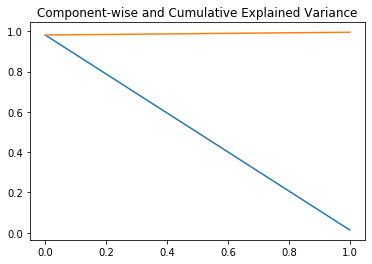

array([[-0.02474539,  0.05029795],
       [-0.0251772 ,  0.19414797],
       [-0.02534596,  0.25042041],
       ...,
       [-0.35026946, -0.36272733],
       [-0.35008522, -0.42411709],
       [-0.35032185, -0.34520555]])

In [419]:
from sklearn.decomposition import PCA

def get_n_components(X: pd.DataFrame, n: int = 5) -> np.ndarray:
    pca = PCA(n_components=n)
    pca_result = pca.fit_transform(X.values)
    plt.plot(range(n), pca.explained_variance_ratio_)
    plt.plot(range(n), np.cumsum(pca.explained_variance_ratio_))
    plt.title("Component-wise and Cumulative Explained Variance")
    plt.show()
    return pca_result

pca_pct = get_n_components(all_pct, n = 2)
pca_pct

*The above shows that 2 components explains 100% of the variance*

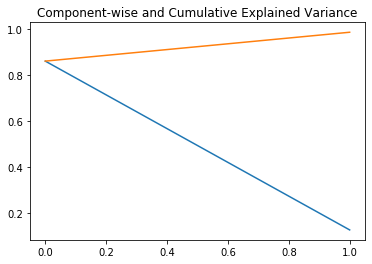

array([[-7776.23271567,  2964.85032551],
       [-7755.37484797,  2951.6764267 ],
       [-7755.0437707 ,  2951.4673172 ],
       ...,
       [14807.00109293,  5695.42787515],
       [14797.06877498,  5701.70116029],
       [14777.20414009,  5714.24772465]])

In [420]:
pca_raw = get_n_components(all_raw, n = 2)
pca_raw

### All: Corr Selection

array(['US Unemp % Change', 'US Median Income % Chg',
       'US ManuEmps % Change', 'NASDAQCOM % Chg', 'US_GDP_%Change'],
      dtype=object)

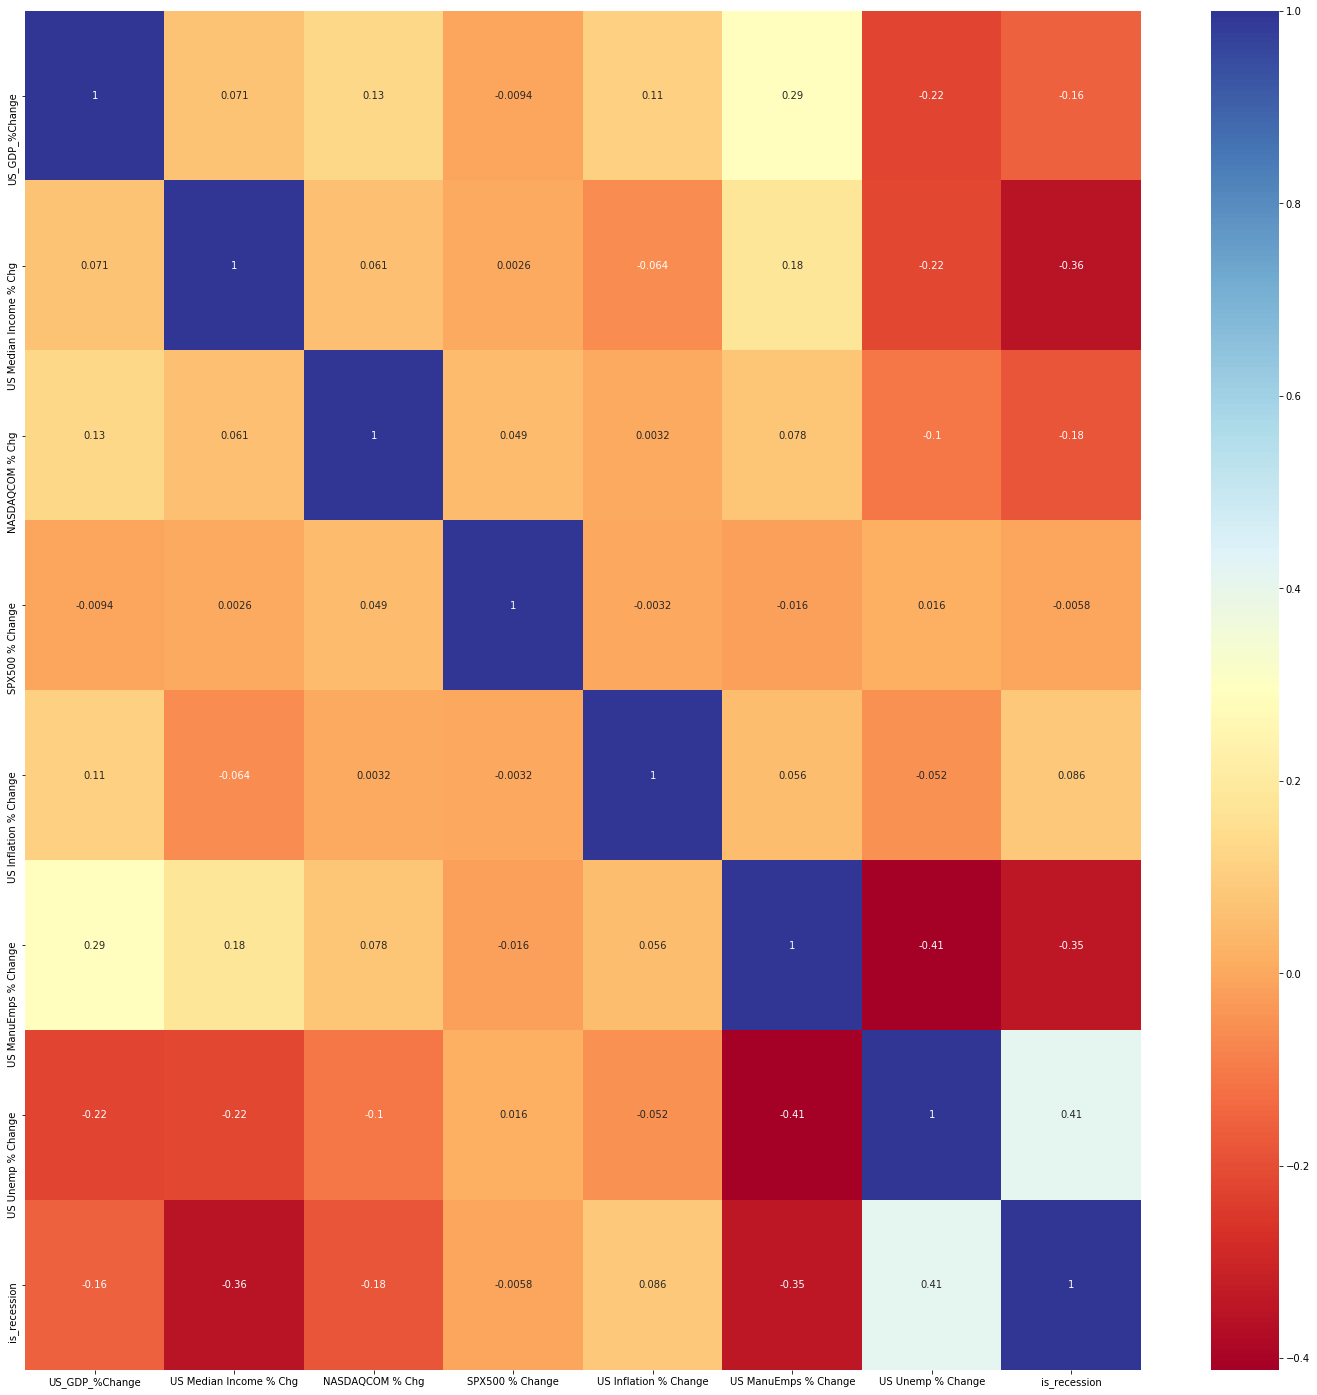

In [421]:
def get_k_corr(df: pd.DataFrame, y: pd.DataFrame, col: str, k: int = 5) -> None:
    """ Plots the correlation matrix and returns the theoretically highest values for the target """
    df = pd.merge(all_pct,df_merged[target],left_index=True,right_index=True,how='inner')
    corr = df.corr(method='kendall')
    ktau_cols = np.array(corr[col].abs().sort_values(ascending=False)[1:51].index)
    plt.figure(figsize=(25,25))
    sns.heatmap(corr, annot=True, cmap="RdYlBu")
    return ktau_cols[:k]

corr_pct_feats = get_k_corr(all_pct, df_merged[target], 'is_recession')
corr_pct_feats

array(['US Unemp % Change', 'US Median Income % Chg',
       'US ManuEmps % Change', 'NASDAQCOM % Chg', 'US_GDP_%Change'],
      dtype=object)

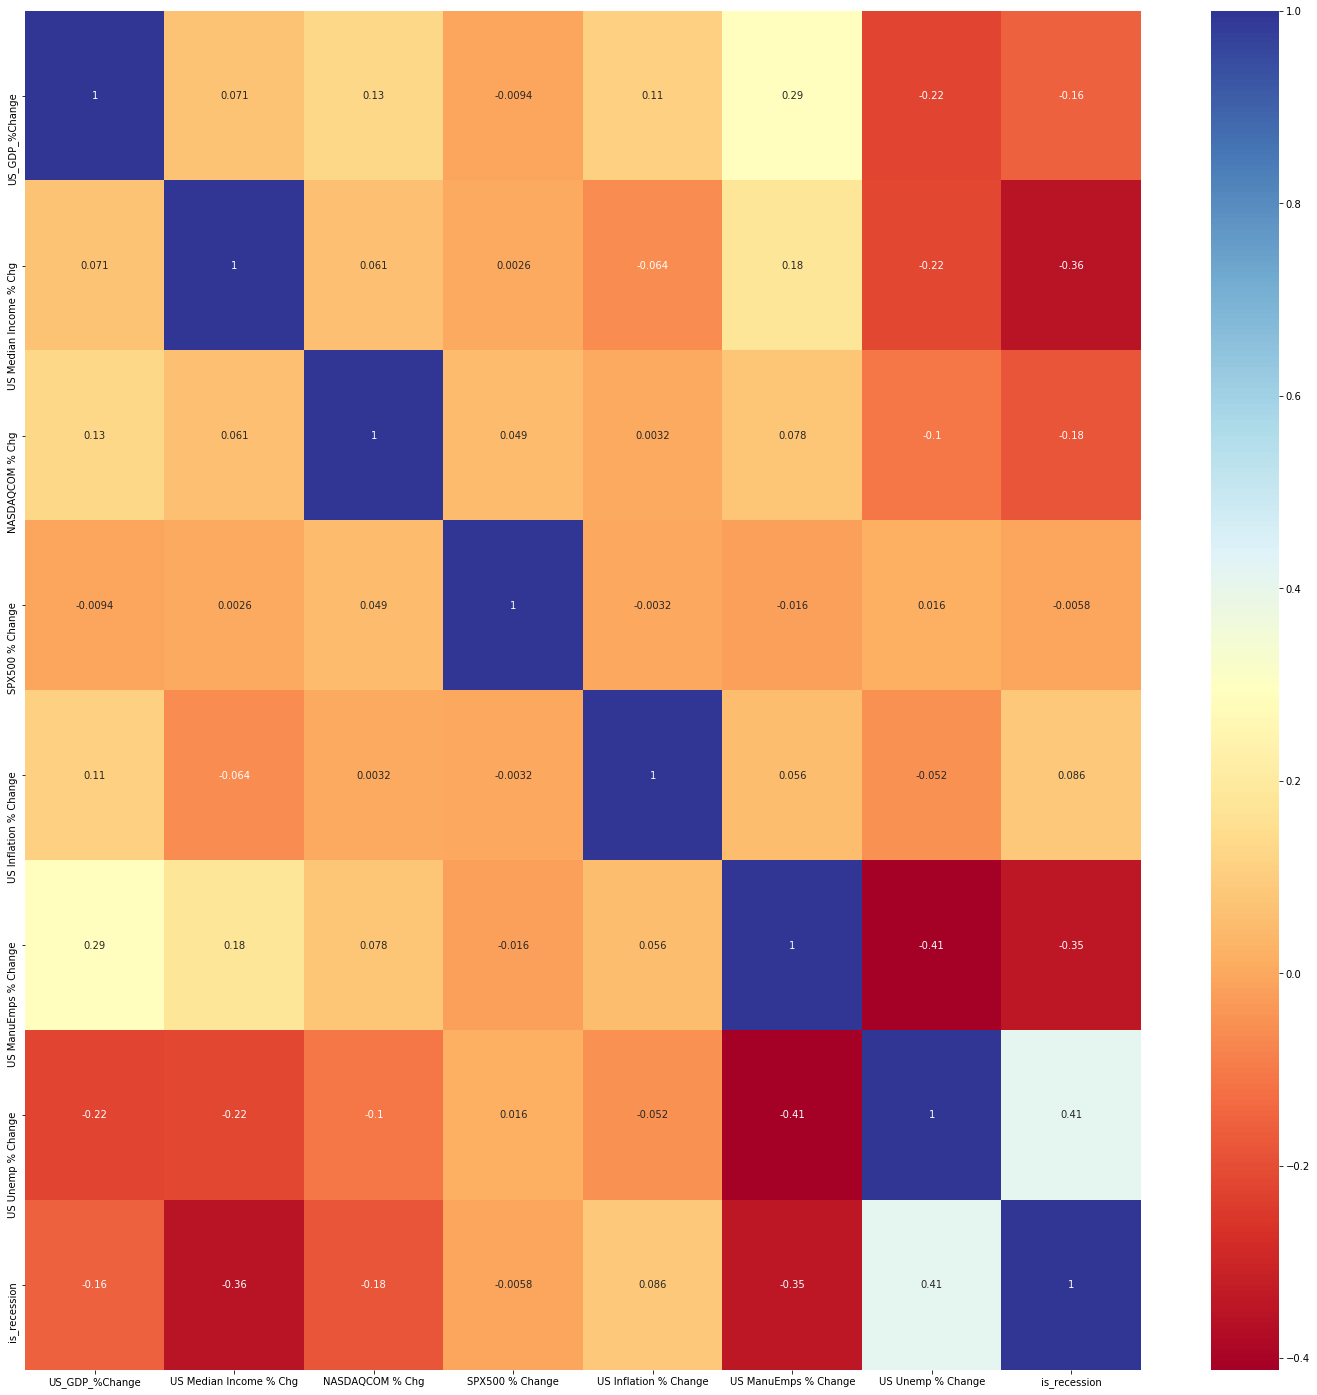

In [422]:
corr_raw_feats = get_k_corr(all_raw, df_merged[target], 'is_recession')
corr_raw_feats

In [423]:
corr_raw = df_merged[corr_raw_feats]
corr_raw

,US Unemp % Change,US Median Income % Chg,US ManuEmps % Change,NASDAQCOM % Chg,US_GDP_%Change
1970-01-01,0.054054,-0.007593,-0.003300,-0.029593,0.012573
1970-02-01,0.200000,-0.007593,-0.003419,-0.029593,0.012573
1970-03-01,0.257143,-0.007593,-0.000054,-0.029593,0.012573
1970-04-01,0.179487,-0.007593,-0.008333,-0.029593,0.015387
1970-05-01,0.142857,-0.007593,-0.009776,-0.029593,0.015387
...,...,...,...,...,...
2020-05-01,2.800000,0.068077,0.020890,-0.141821,-0.094662
2020-06-01,1.522727,0.068077,0.028391,-0.141821,-0.094662
2020-07-01,-0.306122,0.068077,0.003399,0.306317,0.083863
2020-08-01,-0.368421,0.068077,0.002479,0.306317,0.083863


In [424]:
corr_pct = df_merged[corr_pct_feats]
corr_pct

,US Unemp % Change,US Median Income % Chg,US ManuEmps % Change,NASDAQCOM % Chg,US_GDP_%Change
1970-01-01,0.054054,-0.007593,-0.003300,-0.029593,0.012573
1970-02-01,0.200000,-0.007593,-0.003419,-0.029593,0.012573
1970-03-01,0.257143,-0.007593,-0.000054,-0.029593,0.012573
1970-04-01,0.179487,-0.007593,-0.008333,-0.029593,0.015387
1970-05-01,0.142857,-0.007593,-0.009776,-0.029593,0.015387
...,...,...,...,...,...
2020-05-01,2.800000,0.068077,0.020890,-0.141821,-0.094662
2020-06-01,1.522727,0.068077,0.028391,-0.141821,-0.094662
2020-07-01,-0.306122,0.068077,0.003399,0.306317,0.083863
2020-08-01,-0.368421,0.068077,0.002479,0.306317,0.083863


# Everything

In [435]:
everything = df_merged.drop(columns=target)
everything

,US_GDP,US_GDP_%Change,US Unemp,US Unemp % Change,US Inflation,US Inflation % Change,SPX500 % Change,US Median Income,US Median Income % Chg,NASDAQCOM % Chg,10Y-2Y,US ManuEmps % Change,US ManufactureEmps
1970-01-01,1051.200,0.012573,3.9,0.054054,5.838255,0.068810,-0.000626,60120.5,-0.007593,-0.029593,0.356429,-0.003300,18424.0
1970-02-01,1051.200,0.012573,3.9,0.200000,5.838255,0.068810,-0.000626,60120.5,-0.007593,-0.029593,0.356429,-0.003419,18361.0
1970-03-01,1051.200,0.012573,3.9,0.257143,5.838255,0.068810,-0.000626,60120.5,-0.007593,-0.029593,0.356429,-0.000054,18360.0
1970-04-01,1067.375,0.015387,4.6,0.179487,5.838255,0.068810,0.004909,60120.5,-0.007593,-0.029593,0.356429,-0.008333,18207.0
1970-05-01,1067.375,0.015387,4.6,0.142857,5.838255,0.068810,-0.000981,60120.5,-0.007593,-0.029593,0.356429,-0.009776,18029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,19520.114,-0.094662,14.7,2.800000,1.812210,-0.258076,-0.028059,68703.0,0.068077,-0.141821,0.440000,0.020890,11729.0
2020-06-01,19520.114,-0.094662,14.7,1.522727,1.812210,-0.258076,0.003751,68703.0,0.068077,-0.141821,0.520000,0.028391,12062.0
2020-07-01,21157.122,0.083863,10.2,-0.306122,1.812210,-0.258076,0.005022,68703.0,0.068077,0.306317,0.520000,0.003399,12103.0
2020-08-01,21157.122,0.083863,10.2,-0.368421,1.812210,-0.258076,0.005022,68703.0,0.068077,0.306317,0.520000,0.002479,12133.0


In [437]:
all_models = [micro_pct, micro_raw, macro_pct, macro_raw, all_pct, all_raw, anova_pct, anova_raw, 
             pca_raw, pca_pct, corr_pct, corr_raw, everything]
len(all_models)

13

## Models

In [433]:
## y will be target variable
y = np.array(df_merged[target])
y = y.reshape(y.shape[0])

**Logistic Regression Models**

In [430]:
## Example PCA Usage
#### Notice that there is no need to convert it to a ndarray since it is already in that form
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pca_pct, y, test_size=0.2, random_state=0) 
lr = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8254620123203286, 0.7622950819672131)

In [431]:
## Example Micro Usage
X_train, X_test, y_train, y_test = train_test_split(np.array(micro_pct), y, test_size=0.2, random_state=0) 
lr = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8439425051334702, 0.8114754098360656)

**Random Forest Models**

**LSTM Models**

## Reporting

In [ ]:
## Placeholder for reporting

## Canada Data

In [28]:
canada_recession = get_fred_series('CANRECDM', '1970-01-01', 'Recession')
canada_gdp = get_fred_series('MKTGDPCAA646NWDB', '1970-01-01', 'GDP')
canada_gdp_pctcg = get_fred_series('MKTGDPCAA646NWDB', '1970-01-01', 'GDP_%Change', pct_change=True)
unemp = get_fred_series('LRUNTTTTCAM156S', '1970-01-01', 'Unemp')
unemp = unemp.iloc[::3, :]
unemp_pct = get_fred_series('LRUNTTTTCAM156S', '1970-01-01', 'Unemp % Change', pct_change=True, periods=3).iloc[::3, :]
nascom_pct = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM % Chg', pct_change=True, freq='Q')
nascom_pct = nascom_pct.loc[nascom_pct['NASDAQCOM % Chg'].notnull() == True]
nascom_pct.index = nascom_pct.index + pd.Timedelta('1 day')
bond10y = get_fred_series('IRLTLT01CAM156N', '1970-01-01', '10Y-bonds')
canada_inflation = get_fred_series('FPCPITOTLZGCAN', '1970-01-01', 'Inflation')
canada_employees = get_fred_series('LFEAMNTTCAM647S', '1970-01-01', 'ManufactureEmps')
canada_employees_chg = get_fred_series('LFEAMNTTCAM647S', '1970-01-01', 'ManuEmps % Change', pct_change = True).dropna()
loans_pctchg = get_fred_series('TOTCI', '1970-01-01', 'Commercial Loans % Change', pct_change = True, freq = 'M')
loans_pctchg = loans_pctchg.loc[loans_pctchg['Commercial Loans % Change'].notnull() == True]
loans_pctchg.index = loans_pctchg.index + pd.Timedelta('1 day')
canada_medIncome = pd.read_csv('canadaMedIncome.csv').iloc[-1].to_frame().iloc[2:]
canada_medIncome.index = canada_inflation.loc['2000-01-01':'2018-01-01'].index
canada_medIncome['Median Income'] = canada_medIncome[10]
canada_medIncome = canada_medIncome.drop(columns = 10)
canada_medIncome = canada_medIncome.replace(',','', regex=True)
canada_medIncome['Median Income'] = pd.to_numeric(canada_medIncome['Median Income'])

In [29]:
outer = [canada_recession, canada_gdp, canada_gdp_pctcg, bond10y, canada_inflation, canada_employees, canada_employees_chg, loans_pctchg, canada_medIncome]
canada_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='outer'), outer)
inner = [canada_df, unemp, unemp_pct, nascom_pct]
canada_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='inner'), inner)
canada_df = canada_df.iloc[3:-4].fillna(method = 'ffill').loc['1995-01-01':]
canada_df['Median Income'].fillna((canada_df['Median Income'].loc['2000-01-01']), inplace=True)
np.where(canada_df['Recession'] == 1.0)

(array([ 0,  1, 17, 19, 20, 21, 22, 23, 34, 35, 36, 37, 38, 39, 40, 55, 56,
        57, 58, 59, 60, 61, 66]),)

In [32]:
# Just tried this for fun, it is not a legit model yet
# Just tried to see how well America predicts Canada

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#america_test = df_merged[['is_recession','US ManuEmps % Change', 'NASDAQCOM % Chg', 'US Inflation', 'US Unemp % Change', 'US_GDP_%Change']]
#canada_test = canada_df[['Recession', 'ManuEmps % Change', 'NASDAQCOM % Chg', 'Inflation', 'Unemp % Change', 'GDP_%Change']]
#america_test = america_test.rename(columns = {'is_recession' : 'Recession',  'US Inflation' : 'Inflation', 'US Unemp % Change' : 'Unemp % Change', 'US_GDP_%Change' : 'GDP_%Change', 'US ManuEmps % Change': 'ManuEmps % Change'})
#total.drop(total.index, inplace=True)
#total = america_test.append(canada_test, ignore_index = True)

#america_test
X_train, X_test, y_train, y_test = train_test_split(df_merged.drop(columns = ['is_recession']), df_merged['is_recession'], test_size=0.2, random_state=42)
#america_x = america_test.drop(columns = ['is_recession'])
#america_y = america_test['is_recession']
#canada_x = canada_test.drop(columns = ['Recession'])
#canada_y = canada_test['Recession']

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))
confusion_matrix(y_test, clf.predict(X_test))

0.8278688524590164


array([[95,  7],
       [14,  6]])

# Other Countries

In [31]:
us_data.drop(us_data.index, inplace=True)
us_recession = fred.get_series('JHDUSRGDPBR').loc['1970-01-01':].to_frame()
us_recession['isUSRecession'] = us_recession[0]
us_recession = us_recession.drop(columns = 0)

us_gdp = fred.get_series('GDP').loc['1970-01-01':].to_frame()
us_gdp['US_GDP (Billions)'] = us_gdp[0]
us_gdp = us_gdp.drop(columns = 0)

us_gdp_pctcg = fred.get_series('GDP').to_frame().pct_change().loc['1970-01-01':]
us_gdp_pctcg['US_GDP_%Change'] = us_gdp_pctcg[0]
us_gdp_pctcg = us_gdp_pctcg.drop(columns = 0)

unemp = fred.get_series('UNRATE').loc['1970-01-01':].to_frame()
unemp['US Unemp'] = unemp[0]
unemp = unemp.drop(columns = 0).iloc[::3, :]

q_sp500 = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today()).rename(columns = {'Adj Close' : "SPX500 % Change"})["SPX500 % Change"].pct_change()

us_data = pd.merge(us_recession,us_gdp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,us_gdp_pctcg, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,unemp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,q_sp500, how='inner', left_index=True, right_index=True)


japan_data.drop(japan_data.index, inplace=True)
japan_recession = fred.get_series('JPNRECP').loc['1970-01-01':].to_frame()
japan_recession['isJapanRecession'] = japan_recession[0]
japan_recession = japan_recession.drop(columns = 0)

japan_gdp = fred.get_series('JPNNGDP').loc['1970-01-01':'2019-10-01'].to_frame()
japan_gdp['Japan_GDP (Billions of Yen)'] = japan_gdp[0]
japan_gdp = japan_gdp.drop(columns = 0)

japan_data = pd.merge(japan_recession.iloc[::3, :],japan_gdp, how='outer', left_index=True, right_index=True)


UK_data.drop(UK_data.index, inplace=True)
UK_recession = fred.get_series('GBRRECDM').loc['1970-01-01':].to_frame()
UK_recession['isUKRecession'] = UK_recession[0]
UK_recession = UK_recession.drop(columns = 0)

UK_gdp = fred.get_series('UKNGDP').loc['1970-01-01':'2019-10-31'].to_frame()
UK_gdp['UK_GDP (Billions of Pounds)'] = UK_gdp[0]
UK_gdp = UK_gdp.drop(columns = 0)

UK_data = pd.merge(UK_recession.loc[UK_gdp.index], UK_gdp, how='outer', left_index=True, right_index=True)


china_data.drop(china_data.index, inplace=True)
china_recession = fred.get_series('CHNRECM').loc['1970-01-01':].to_frame()
china_recession['isChinaRecession'] = china_recession[0]
china_recession = china_recession.drop(columns = 0)
china_recession = china_recession.iloc[::12, :]

china_gdp = fred.get_series('MKTGDPCNA646NWDB').loc['1978-01-01':'2019-10-31'].to_frame()
china_gdp['China_GDP (Dollars)'] = china_gdp[0]
china_gdp = china_gdp.drop(columns = 0)

china_data = pd.merge(china_recession, china_gdp, how='outer', left_index=True, right_index=True)


euro_data.drop(euro_data.index, inplace=True)
euro_recession = fred.get_series('EUROREC').loc['1970-01-01':].to_frame()
euro_recession['isEuroRecession'] = euro_recession[0]
euro_recession = euro_recession.drop(columns = 0)

euro_gdp = fred.get_series('EUNNGDP').loc['1970-01-01':].to_frame()
euro_gdp['Euro_GDP (Millions of Euros)'] = euro_gdp[0]
euro_gdp = euro_gdp.drop(columns = 0)

euro_data = pd.merge(euro_recession.iloc[::3, :], euro_gdp.iloc[:-2], how='outer', left_index=True, right_index=True)


canada_data.drop(canada_data.index, inplace=True)
canada_recession = fred.get_series('CANRECDM').loc['1970-01-01':].to_frame()
canada_recession['isCanadaRecession'] = canada_recession[0]
canada_recession = canada_recession.drop(columns = 0)
canada_recession = canada_recession.loc[canada_gdp.index]

canada_gdp = fred.get_series('MKTGDPCAA646NWDB').loc['1970-01-01':].to_frame()
canada_gdp['Canada_GDP (Dollars)'] = canada_gdp[0]
canada_gdp = canada_gdp.drop(columns = 0)

canada_data = pd.merge(canada_recession, canada_gdp, how='outer', left_index=True, right_index=True)


india_data.drop(india_data.index, inplace=True)
india_recession = fred.get_series('INDREC').loc['1970-01-01':].to_frame().iloc[11:]
india_recession['isIndiaRecession'] = india_recession[0]
india_recession = india_recession.drop(columns = 0).iloc[::12, :]

india_gdp = fred.get_series('MKTGDPINA646NWDB').loc['1970-01-01':].to_frame()
india_gdp['India_GDP (Dollars)'] = india_gdp[0]
india_gdp = india_gdp.drop(columns = 0)

india_data = pd.merge(india_recession, india_gdp, how='outer', left_index=True, right_index=True)


germany_data.drop(germany_data.index, inplace=True)
germany_recession = fred.get_series('DEUREC').loc['1970-01-01':].to_frame()
germany_recession['isGermanyRecession'] = germany_recession[0]
germany_recession = germany_recession.drop(columns = 0).iloc[::12, :]

germany_gdp = fred.get_series('MKTGDPINA646NWDB').loc['1970-01-01':].to_frame()
germany_gdp['Germany_GDP (Dollars)'] = germany_gdp[0]
germany_gdp = germany_gdp.drop(columns = 0)

germany_data = pd.merge(germany_recession, germany_gdp, how='outer', left_index=True, right_index=True)


swiss_data.drop(swiss_data.index, inplace=True)
swiss_recession = fred.get_series('CHEREC').loc['1970-01-01':].to_frame()
swiss_recession['isSwissRecession'] = swiss_recession[0]
swiss_recession = swiss_recession.drop(columns = 0).iloc[::3, :]

swiss_gdp = fred.get_series('CPMNACSAB1GQCH').loc['1970-01-01':].to_frame()
swiss_gdp['Swiss_GDP (Dollars)'] = swiss_gdp[0]
swiss_gdp = swiss_gdp.drop(columns = 0)

swiss_data = pd.merge(swiss_recession, swiss_gdp, how='outer', left_index=True, right_index=True)


korea_data.drop(korea_data.index, inplace=True)
korea_recession = fred.get_series('KORRECD').loc['1970-01-01':].to_frame()
korea_recession['isKoreaRecession'] = korea_recession[0]
korea_recession = korea_recession.drop(columns = 0)

korea_gdp = fred.get_series('KORGDPNQDSMEI').loc['1970-01-01':].to_frame()
korea_gdp['Korea_GDP (Korean Won)'] = korea_gdp[0]
korea_gdp = korea_gdp.drop(columns = 0)

korea_data = pd.merge(korea_recession.loc[korea_gdp.index[:-3]], korea_gdp, how='outer', left_index=True, right_index=True)


aus_data.drop(aus_data.index, inplace=True)
aus_recession = fred.get_series('AUSRECM').loc['1970-01-01':].to_frame()
aus_recession['isAusRecession'] = aus_recession[0]
aus_recession = aus_recession.drop(columns = 0).iloc[::3, :]

aus_gdp = fred.get_series('AUSGDPNQDSMEI').loc['1970-01-01':].to_frame()
aus_gdp['Aus_GDP (Australian Dollars)'] = aus_gdp[0]
aus_gdp = aus_gdp.drop(columns = 0)

aus_data = pd.merge(aus_recession, aus_gdp, how='outer', left_index=True, right_index=True)


russia_data.drop(russia_data.index, inplace=True)
russia_recession = fred.get_series('RUSRECM').loc['1995-01-01':].to_frame()
russia_recession['isRussiaRecession'] = russia_recession[0]
russia_recession = russia_recession.drop(columns = 0).iloc[::12, :].dropna()

russia_gdp = fred.get_series('MKTGDPRUA646NWDB').loc['1970-01-01':].to_frame()
russia_gdp['Russia_GDP (US Dollars)'] = russia_gdp[0]
russia_gdp = russia_gdp.drop(columns = 0)

russia_data = pd.merge(russia_recession, russia_gdp, how='outer', left_index=True, right_index=True)



other_countries = [japan_data, UK_data, china_data, euro_data, canada_data, india_data, germany_data, swiss_data, korea_data, aus_data, russia_data]

NameError: name 'us_data' is not defined

In [ ]:
# merge is the final combined DF of all countries
merge.drop(merge.index, inplace=True)
merge=pd.merge(us_data,japan_data, how='inner', left_index=True, right_index=True)
for i in other_countries[1:]:
    merge=pd.merge(merge,i, how='outer', left_index=True, right_index=True)

In [ ]:
merge.to_excel('GDP_Recession_DF.xlsx')

In [ ]:
merge

In [ ]:
us_data.drop(us_data.index, inplace=True)
us_recession = fred.get_series('JHDUSRGDPBR').loc['1970-01-01':].to_frame()
us_recession['isUSRecession'] = us_recession[0]
us_recession = us_recession.drop(columns = 0)

us_gdp = fred.get_series('GDP').loc['1970-01-01':].to_frame()
us_gdp['US_GDP (Billions)'] = us_gdp[0]
us_gdp = us_gdp.drop(columns = 0)

us_gdp_pctcg = fred.get_series('GDP').to_frame().pct_change().loc['1970-01-01':]
us_gdp_pctcg['US_GDP_%Change'] = us_gdp_pctcg[0]
us_gdp_pctcg = us_gdp_pctcg.drop(columns = 0)

unemp = fred.get_series('UNRATE').loc['1970-01-01':].to_frame()
unemp['US Unemp'] = unemp[0]
unemp = unemp.drop(columns = 0).iloc[::3, :]

q_sp500 = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today()).rename(columns = {'Adj Close' : "SPX500 % Change"})["SPX500 % Change"].pct_change()

us_data = pd.merge(us_recession,us_gdp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,us_gdp_pctcg, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,unemp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,q_sp500, how='inner', left_index=True, right_index=True)
us_data